# `DSML Workshop 08` - Advanced Regression

In this workshop we continue with hands-on supervised learning (regression). 

We will cover the following: 
1. **Task**: Predicting electricity demand (continued)
1. **Regularization**: L1 (LASSO) and L2 (ridge) regression
1. **General non-linear features**: Radial Basis Functions
1. **Other regression algorithms**: Overview of some selected algorithms

---

## 1. Task: Predicting electricity demand (continued)

Last week, we used electricity load data from Pittsburgh to predict peak electricity demand based on temperature using polynomial features. Let us put what we learned into practice by predicting **average electrical load** from **average temperature** using `scikit learn`. To do so follow the steps below:

- Define your X and y vectors.
- Define a train and test datasets using `train_test_split`
- Create empty lists to store the training and validation mean squared errors.
- Write a simple loop for degrees ranging from 0-50 in which you 
    - create the polynomial features using `PolynomialFeatures` with variable degree inputs and `fit_transform`
    - initialize and fit the model using `LinearRegression`
    - compute and append the errors to your error lists
- Illustrate the training and validation errors for different polynomial degrees.

In [4]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# load data
df = pd.read_csv("Pittsburgh_load_data.csv")
df.head()

In [ ]:
# define X and y vectors
xa = df["Avg_temp"]
ya = df["AVG"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(xa, ya, test_size=0.3, random_state=42)

# define loop 
err_train = []
err_cv = []

DEG_RANGE = range(50)

for deg in DEG_RANGE: # we want to loop across 0-50 degrees
    
    # create poly features
    poly_feat = PolynomialFeatures(degree=deg)
    X_train_poly=poly_feat.fit_transform(X_train.values.reshape((-1,1)))      # X_train_poly is set to be a m x n matrix (m = observations, n = features)
    X_test_poly=poly_feat.fit_transform(X_test.values.reshape((-1,1)))        # X_test_poly is set to be a m x n matrix (m = observations, n = features)
    
    # initialize and fit model
    lin_mod_poly = LinearRegression()
    lin_mod_poly.fit(X_train_poly,y_train)
    
    # compute errors and append to err_train and err_cv
    err_train.append(mean_squared_error(y_train,lin_mod_poly.predict(X_train_poly)))
    err_cv.append(mean_squared_error(y_test,lin_mod_poly.predict(X_test_poly)))

# plot results
plt.figure(figsize = (8,6))    
plt.semilogy(DEG_RANGE, err_train, DEG_RANGE, err_cv)
#plt.semilogy(range(9), err_train[:9], range(9), err_cv[:9])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.show()

---

## 2. Regularization: L1 (LASSO) and L2 (ridge) regression

### `Recap`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

We continue with our electric power example from last week which we retieved from PJM from [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition). The files we are loading are the raw files we downloaded from this source. The final input data for our code is `Pittsburgh_load_data.csv`.

In [11]:
df = pd.read_csv("Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df["Month"] = df["Date"].dt.month
df.head()

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month
0,2013-01-01,1.598524,1.859947,0.001599,38.368031,0.0,-1.68,1
1,2013-01-02,1.809347,2.054215,0.001809,43.428194,-3.9,-6.58,1
2,2013-01-03,1.832822,2.049550,0.001833,43.991607,0.6,-6.12,1
3,2013-01-04,1.812699,2.008168,0.001813,43.508609,0.0,-1.95,1
4,2013-01-05,1.662036,1.838251,0.001662,39.892360,1.7,-1.47,1


**Recall from our previous workshop**: We fitted a polynomial model to the full range of electricity data. To do so, we used `scikit learn` and obtained the following result:

In [12]:
xp = df["High_temp"]
yp = df["MAX"]

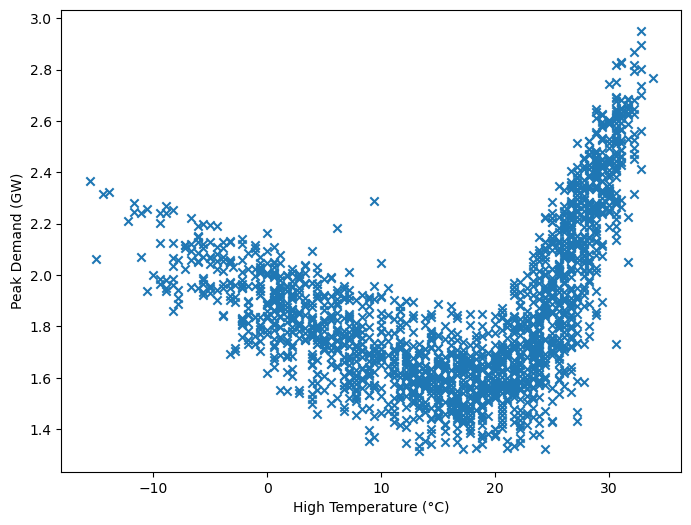

In [13]:
plt.figure(figsize = (8,6))
plt.scatter(xp, yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

In [14]:
# x is the input variable
# y is the output variable
# d is the degree of polynomial regression

def plot_regression_poly(x, y, d):
    
    # create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2 * (x - min_x)/(max_x - min_x) - 1          # rescale to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # implement polynomial regression using analytical least squares solution: theta = (X'X)^-1 X'y
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    
    # create scaled test dataset
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2 * (xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print("The first 4 elements of Theta are equal to: ", np.round(theta[:4], 2))
    print("The last 4 elements of Theta are equal to: ", np.round(theta[-4:], 2))
    plt.show()

The first 4 elements of Theta are equal to:  [ -969759.06 -2383810.89  1145312.33  1760055.66]
The last 4 elements of Theta are equal to:  [-7.96 -1.02 -0.36  1.69]


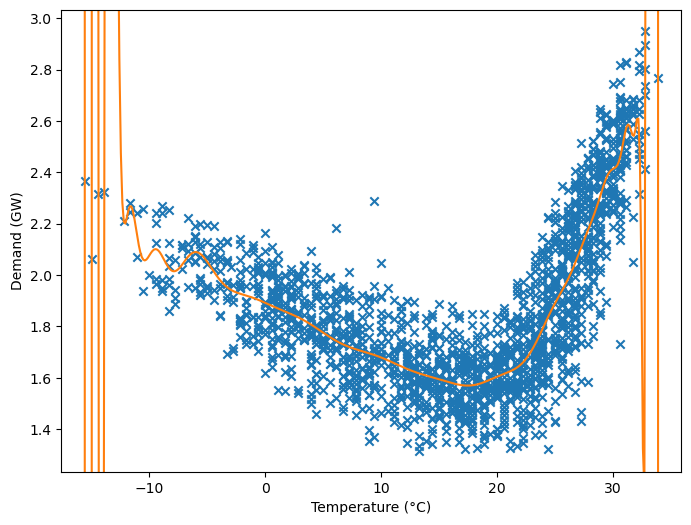

In [15]:
plot_regression_poly(xp, yp, d=100)

### `Regularization` (by hand)

We have so far seen that the degree of the polynomial we use for our nonlinear features acts as a nice characterization of the model complexity.  But there is another notion of model complexity that is also important to understand, the _magnitude_ of the model parameters.  To see why this is important, let's look again at our degree 100 polynomial fit to the data above. Let's also look at the actual weights involved with this fit.

The way that we get the polynomial to exactly pass through the points requires extremely high values for the coefficients: we need to set the coefficients just so that the different polynomial terms largely “cancel” out precisely at the data points and fit the function exactly to the data.

This also suggests another method for controlling the complexity of the model class: 
restricting the magnitude of the coefficients. This is the basis of the technique known as regularization.

Formally, regularization is often written as an additional term in the canonical machine learning problem.  Instead of simply minimizing the average loss, we minimize the average loss plus a term that penalizes the magnitude of the coefficients (usually some function of a norm of the weights, often just the sum of squared weights also called $\ell_2$ regularization, but other functions are possible as well).  For example, let's consider the following optimization problem:
\begin{equation}
\underset{\theta}{minimize} \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)}),y^{(i)} \right) + \lambda \sum_{i=1}^n \theta_i^2
\end{equation}
where $\lambda \in \mathbb{R}_+$ is what is called a _regularization parameter_.  $\lambda$ effectively trades off between minimizing the training loss (which naturally "wants" to use large weights), and keeping the weights small.  If $\lambda = 0$, we ignore the regularization term entirely, and just minimize training loss; but as $\lambda \rightarrow \infty$, the _only_ relevant term in the optimization problem becomes the sum of the squared weights, which is clearly minimized if we just pick $\theta = 0$.  Thus, by varying $\lambda$ between zero and some very large constant, we can "sweep out" different ranges of model complexity.

#### Visualizing regularization
Let's see what this looks like on our 100 degree polynomial.  The figure above shows the situation with no regularization, i.e, $\lambda = 0$.  If we instead choose $\lambda = 1$, we get the following figure.

In [ ]:
# x is the input variable
# y is the output variable
# d is the degree of polynomial regression
# lam is lambda, the degree of regularization

def plot_regularized_polyregression (x, y, lam, d):
    
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1
    X = np.array([xs**i for i in range(d,-1,-1)]).T

    theta = np.linalg.solve(X.T @ X + lam * np.eye(X.shape[1]), X.T @ y)  # see lecture notes for derivation! Note: np.eye() returns the identity matrix

    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print("The first 4 elements of Theta are equal to: ", np.round(theta[:4], 2))
    print("The last 4 elements of Theta are equal to: ", np.round(theta[-4:], 2))
    plt.show()

In [ ]:
plot_regularized_polyregression (xp, yp, lam=1, d=100)

What happens if we regularize further? As we increase the value of lambda, the underlying function looks generally smoother (again, focusing mainly on the data between the extreme points).

In [ ]:
plot_regularized_polyregression (xp, yp, lam=100, d=100)

We can also understand what is happening here by reference to the previous workshop when we discussed polynomial fittings as a function of the degree of the polynomial.  Remember that after degree 10 or so, there wasn't a huge benefit of including additional polynomial terms in the regression.  Yet, if we include these terms within the context of a traditional least squares fit, we have seen that in order to use the polynomial degree to minimize the error (essentially done by "exactly" passing through some of the points), this is accomplished by a very high weight on the high-order coefficients.

So what happens when we apply a regularization penalty?  Because we know that we can achieve low error with a lower-degree polynomial, if we add sufficient regularization to the optimization objective, this will have the effect of avoiding putting much weight on the high-order terms in the polynomial, and just putting the weight on the lower order terms.  We can verify this by looking at the magnitude of the actual coefficients of $\theta$ before and after regularization (remember, $\theta$ is ordered in higher-to-lower degree polynomial terms, so we will flip the order to correspond to increasing degree of the polynomial terms).

In [ ]:
def ls_poly_reg(x, y, lam, degree):
    xs = 2*(x - min(x))/(max(x) - min(x)) - 1                   # rescale to range [-1,1]
    X = np.array([xs**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

In [ ]:
# define inputs
x=xp
y=yp
lam= 1
degree= 50

# plot function
theta = ls_poly_reg(x, y, lam, degree)

plt.figure(figsize = (8,6))
plt.semilogy(range(degree+1), np.abs(theta[::-1]))      # reverse order of theta (absolute)
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")
plt.show()

**Question: What do you observe as you change the degree of polynomial and the regularization parameter?**

### Regularization using `scikit learn`

#### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization. This is the process we have implemented manually above. It proceeds by penalizing the sum of squares (L2-norm) of the model coefficients; in this case, the penalty on the model fit would be $P = \alpha\sum_{n=1}^N \theta_n^2$ where $\alpha$ is a free parameter that controls the strength of the penalty (note that this is equivalent to our $\lambda$ from above). This type of penalized model is built into Scikit-Learn with the Ridge estimator:

Quick recap: we first create polynomial features using the `PolynomialFeatures` module in `scikit learn`. Second, we standardize the input data, which you should always do when using Ridge (or Lasso) regression.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# initialize model
Poly = PolynomialFeatures(degree = 50, include_bias=False)

# fit and transform x_norm
X_poly = Poly.fit_transform(xp.values.reshape(-1,1))

# scale input features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

In [ ]:
from sklearn.linear_model import Ridge

We then import the `Ridge` regression model:

In [ ]:
# initialize model
model_L2 = Ridge(alpha = 0.01, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(X_poly_scaled, yp)

# predict
prediction = model_L2.predict(X_poly_scaled)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

In [ ]:
# function for plotting

def plot_scikit_output(x, y, fitted_model):
    
    # create, normalize and generate polynomial features to plot predictions
    min_x, max_x = x.min(), x.max()
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
    xt0_poly_scaled = scaler.transform(xt0_poly)
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, fitted_model.predict(xt0_poly_scaled), 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    plt.show()

plot_scikit_output(xp, yp, model_L2)

#### LASSO regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients: 
$$P = \alpha\sum_{n=1}^N |\theta_n|$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero. As a result, Lasso can be readily used as an embedded method for feature selection.

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
# initialize model
model_L1 = Lasso(alpha = 0.01)

model_L1.fit(X_poly_scaled, yp)
predict = model_L1.predict(X_poly_scaled)

print("Coefficients ", model_L1.coef_, "\nIntercept ", model_L1.intercept_ )

plot_scikit_output (xp, yp, model_L1)

### Regularization and cross-validation performance

We can also illustrate the effects of regularization as they relate to training and validation performance.  Just as we did with the degree of the polynomial, we can consider the training and validation errors for different amounts of regularization.

In [ ]:
Grid_Search_Range = np.logspace(-15, 5, 100)    # Create 100 evenly paced numbers in between 10^-15 and 10^5

def plot_L2_regression_performance (x, y, deg):

    # Errors for Training and Testset
    err_train = []
    err_cv = []
    
    # Scale input vectors to [-1,1]
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1

    #Train-Test-Split
    x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.3, random_state = 10)

    #Polynomials
    X_train_scaled_poly = np.array([x_train**i for i in range(deg,-1,-1)]).T
    X_test_scaled_poly = np.array([x_test**i for i in range(deg,-1,-1)]).T
    
    for alpha in Grid_Search_Range:
        # Fit coefficients on Test Set
        theta_ridge = np.linalg.solve(X_train_scaled_poly.T @ X_train_scaled_poly + alpha*np.eye(X_train_scaled_poly.shape[1]), X_train_scaled_poly.T @ y_train)

        # Compute Predictions
        y_hat_train = X_train_scaled_poly @ theta_ridge
        y_hat_test = X_test_scaled_poly @ theta_ridge
    
        # compute errors
        err_train.append(mean_squared_error(y_train, y_hat_train))
        err_cv.append(mean_squared_error(y_test, y_hat_test))


    plt.figure(figsize = (8,6))
    plt.loglog(Grid_Search_Range, err_train,
               Grid_Search_Range, err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("lambda (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    #plt.xlim(10**(-4))
    #plt.ylim(0.01, 10)
    plt.show()

plot_L2_regression_performance(xp, yp, 100)

A few points are worth emphasizing here.  First, the nature of the regularization term: lower $\lambda$ means _less_ regularization, whereas larger $\lambda$ correspond to more regularization (eventually just essentially corresponding to all zero weights).  Thus, larger $\lambda$ means _lower_ model complexity, so the x-axis of the figure above works in the opposite direction as in the polynomial degree example.  Second, also note that we are using a _logarithmic_ scale on the x-axis (and the y-axis, as before, but the x-axis is the important part here).  This means that regularization typically works on a scale of _orders of magnitude_.  If you search over possible regularization terms, you'll want to do this search over a logarithmic space, because you need very large changes to the magnitude of $\lambda$ to really illustrate the full differences.  Third and last, just as was the case for the polynomial degree, we emphasize that the cross validation error is not a nice unimodal function of $\lambda$; there are multiple local optima owing to the pecularities of the particular polynomial, and it is not easy to globally optimize $\lambda$ by looking at cross validation error in some local region alone.  For this reason, techniques like grid searches are often more common in practice for finding model hyperparameters (including the $\lambda$ term), instead of techniques like gradient-based optimization.

---

## 3. General non-linear features

Using polynomials served as as good illustration of the basic principles of nonlinear features, generalization, and regularization, but they are far from the only such type of feature used in practice (and indeed, polynomials are probably a bit less common in most cases than other feature classes).  We also only covered polynomials for one dimensional "raw" inputs, where it was easy to enumerate all possible polynomials.  In this section, we'll cover another type of common nonlinear feature - radial basis functions - and illustrate how to create both polynomials and radial basis functions over multi-dimensional raw inputs.

For the purposes of this section, we're going to adopt a slightly more explicit notation.  Specifically, whereas before we used $x^{(i)}$ to generally refer to the input features to the algorithm, here we're going to use $x^{(i)} \in \mathbb{R}^n$ (or often just $x \in \mathbb{R}^n$, if we don't need to index over a data set), to refer to just the "raw" input features: i.e., in the case of our peak demand prediction problem, $x$ would just refer to the high temperature
\begin{equation}
x^{(i)} \in \mathbb{R}^1 = \left [ \; \mathrm{HighTemperature}^{(i)} \; \right ]
\end{equation}
The raw inputs need not always be one dimensional, of course, for instance we previously used the example of including both the temperature and a day of the week flag as features
\begin{equation}
x^{(i)} \in \mathbb{R}^2 = \left [ \begin{array}{c} \mathrm{HighTemperature}^{(i)} \\ \mathrm{IsWeekday}^{(i)} \end{array} \right ]
\end{equation}

Note that here, we don't include any of the polynomial features directly in $x$; instead, $x$ only captures the true underlying inputs to the algorithm, the elements that we are providing that are not derived from other quantities (and note that it also doesn't include the constant feature, for instance).  Instead, we'll define a _feature mapping_
\begin{equation}
\phi : \mathbb{R}^n \rightarrow \mathbb{R}^k
\end{equation}
to be a function that maps $n$-dimensional inputs to $k$ dimensional _features_.  Everything else remains the same, except that we now consider the hypothesis function that is linear in these feature vectors, i.e.,
\begin{equation}
h_{\theta}(x) = \theta^T \phi(x)
\end{equation}
parameterized by $\theta \in \mathbb{R}^k$.

For example, for a degree-3 polynomial (in one input variable), we can define $\phi : \mathbb{R} \rightarrow \mathbb{R}^4$ as
\begin{equation}
\phi(x) = \left [ \begin{array}{c} x^3 \\ x^2 \\ x \\ 1 \end{array} \right ]
\end{equation}
and similarly for larger degree
polynomials.  Hopefully, it is clear that this is just a notational definition.

### `Radial basis function (RBF)`

If I were to make a completely anecdotal estimate, I would guess that the most frequently used type of nonlinear feature is not the polynomial, but something called the _radial basis function_, often abreviated as RBF.  Radial basis functions are similar to polynomials in that they are non-linear functions of the input data, but they are notably different in that they are generally _local_ features: the value of any particular feature is close to zero for most of the input space, but non-zero in a small region around a "center" parameter.  Let's start with the definition, and we can then provide some illustrations that hopefully make this more concrete.  To keep things simple at the start, we're only going to consider radial basis functions of one-dimensional raw inputs.  A radial basis function feature vector is defined as the following:
$$
\phi : \mathbb{R} \rightarrow \mathbf{R}^k = \left[ \begin{array}{c} 
\exp \left(\frac{-(x - \mu^{(1)})^2}{2\sigma^2} \right) \\
\exp \left(\frac{-(x - \mu^{(2)})^2}{2\sigma^2} \right) \\
\vdots \\
\exp \left(\frac{-(x - \mu_{(k-1)})^2}{2\sigma^2} \right) \\
1
\end{array} \right]
$$




where $\mu^{(1)},\ldots,\mu^{(k-1)} \in \mathbb{R}$ (called the means) and $\sigma \in \mathbb{R}$ (called the bandwidth) are the hyperparameters of this feature vector.  

Let's look at a single one of these terms $\phi_j(x)$ (this is the $j$th element of the feature vector, because remember $\phi(x)$ outputs a $k$-dimensional vector).
\begin{equation}
\phi_j(x) = \exp \left(\frac{-(x - \mu^{(j)})^2}{2\sigma^2} \right)
\end{equation}
If you're familiar with the Gaussian distribution, you may recognize this as looking similar to the density function of the Gaussian (though without the normalizing constant). One single dimension of this feature (for varying inputs $x$, and here assuming mean $\mu^{(j)} = 2$ and $\sigma = 0.5$) looks like the following:

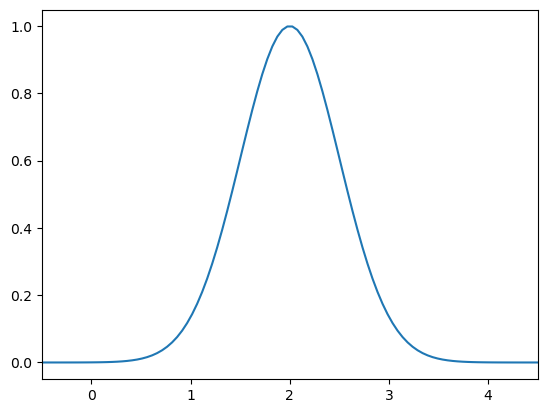

In [ ]:
x = np.linspace(-0.5,4.5,100)
mu = 2
sigma = 0.5

plt.plot(x, np.exp(-(x-mu)**2 / (2*sigma**2)))
plt.xlim([-0.5,4.5])
plt.show()

A feature vector with k=10 RBF centers (i.e. 9 RBF features plus a constant term) would look like the following:

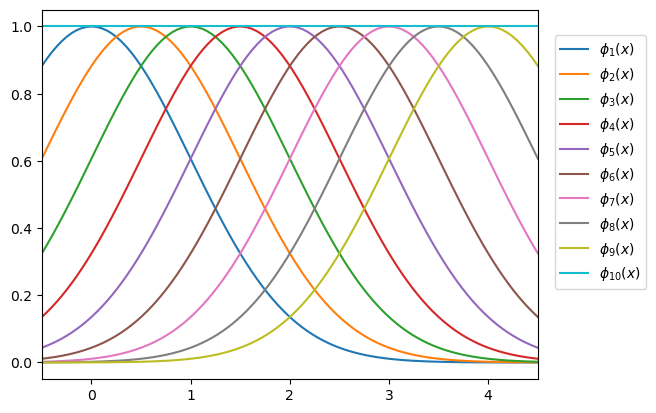

In [6]:
x = np.linspace(-0.5,4.5,100)
mu = np.linspace(0, 4, 9) 
sigma = 1

for mu_ in mu:
    plt.plot(x, np.exp(-(x-mu_)**2 / (2*sigma**2)))
plt.plot([-0.5,4.5], [1,1])
plt.xlim([-0.5,4.5])
plt.legend([r"$\phi_{" + str(j+1) + "}(x)$" for j in range(10)], bbox_to_anchor=(1.02,0.95))
plt.show()

The goal of nonlinear fitting with RBFs is to approximate the underlying function with a linear combination of these features.  By combining them in a proper manner, it is possible to approximate very general functions.

To see this, let's go back again to the nonlinear version of the peak demand prediction problem.  We can construct a set of 10 dimensional RBFs spanning the minimum and maximum values of $x$.  For simplicity, we choose $\sigma$ to be equal to the distance between the means (this was done above, and seems reasonable, though we'll consider other ways of choosing $\sigma$ below).  Note also that there is no need to normalize the data, because the RBF features will always be scaled to be between zero and one (we could further normalize the generated features themselves, but this is typically not needed, as the features by definition will already be scaled to the range $[0,1]$).

In [ ]:
# Function: Create RBF features
def rbf_feat(x, mu, sig):
    x = np.array(x)
    return np.hstack([np.exp(-(x.reshape(-1,1) - mu)**2/(2*sig**2)), np.ones((len(x),1))])    # Creates a feature matrix with rbfs

# Function: Use RBFs to determine the coefficients theta
def train_rbf(x, y, n_rbf):                             # See lecture_8_Regression2: Slide 28
    min_x, max_x = x.min(), x.max()                     # Determines min and max values of x
    mu = np.linspace(min_x, max_x, n_rbf-1)             # Evenly segments the interval [min_x, max_x] and computes n_rbf-1 mu-values
    sig = (max_x - min_x)/(n_rbf-1)                     # Choose sig to be equal to the distance between mus
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi, Phi.T @ y)     # Theta_ridge looks similar to simple regression: theta_ols = (X'X)^-1 X'y
    return theta, mu, sig

# Function for plotting
def plot_regression_rbf(theta, mu, sig):
    xt = np.linspace(-20,35, 400)
    yt = rbf_feat(xt, mu, sig) @ theta                 # yt are the predicted values!
    
    plt.figure(figsize = (8,6))
    plt.scatter(df["High_temp"], df["MAX"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Peak Demand (GW)")
    plt.xlim([-18,35])
    plt.ylim(ylim)
    plt.show()                  

In [ ]:
plot_regression_rbf(*train_rbf(xp, yp, 10)) # the train_rbf function returns a tuple with 3 elements (theta, mu, sigma); the asterisk "unpacks" this tuple so that the three elements are passed to our plot_regression_rbf as three separate objects

### Hyperparameters in RBFs
Unlike polynomials, where the only real hyperparameter relevant to the features themselves (not the regularization) is the degree of the polynomial, for RBF features there are a number of hyperparameter choices: the choice of centers themselves (and the number of centers as highlighted above), the bandwidth parameter $\sigma$, and the regularization parameter $\theta$.  It can be somewhat understood intuitively how we might trade off between all these different choices, and the good news is that there are some rules of thumb for choosing reasonable values for many of the hyperparameters without resorting to a grid search.  However, for the time being, we do want to briefly highlight the effect that the different hyperparameters have on the resulting performance.

**Effect of centers** We have already seen how the number of centers affects the fit of the data, so we will just briefly mention here that while the "obvious" choice for RBF centers on 1D data is to simply use an even grid over the input space, this doesn't work well for higher dimensions.

**Effect of regularization** Just like with polynomial features, we can add regularization to additionally smooth the function.  Unlike regularization for polynomial features, however, with a lot of narrow-peaked RBF functions, it is not trivial to fit the data with small weights.  This is precisely due to the local nature of the RBF features.  Because each features is only non-zero for a small part of the input space, we often cannot find a good fit to the data that has very low weights: there is no equivalent to the "just choosing low degree terms" as we did for the polynomial.

**Effect of bandwidth parameter** The effect of the bandwidth parameter, $\sigma$, can be somewhat less obvious.  At a high-level, though, the intuition that is important here is that larger $\sigma$ leads to _smoother_ feature RBF functions, which in turn leads to smoother final functions.

---

## 4. Some other regression techniques

So far we have only talked about parameterized regression algorithms, i.e. algorithms that make relatively strong assumptions about the functional relationship between features and dependent variable (i.e. the target).

### `KNN regression`

Regression based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

Out of all the machine learning algorithms, KNN is easily the simplest to pick up. Despite it’s simplicity, it has proven to be effective at certain tasks. KNN can be used for both classification and regression problems. Although it is far more popular for classification problems it can perform well in regression tasks as well. One of the benefits of KNN is that it is an **unparametric** algorithm, i.e it does not make strong assumptions about the form of the mapping function. By not making assumptions, KNN is free to learn any functional form from the training data. 

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

In [ ]:
# initialize
KNN_reg = KNeighborsRegressor(n_neighbors=25) # specify the number of neighbors you want to use

# train
KNN_model = KNN_reg.fit(x_train.values.reshape(-1,1), y_train) 

# predict
y_hat_KNN = KNN_model.predict(x_test.values.reshape(-1,1))

In [ ]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_test, y_hat_KNN), "GW")
print("RMSE:",(mean_squared_error(y_test, y_hat_KNN))**(0.5), "GW")  
print("R2:",r2_score(y_test, y_hat_KNN))

Let us visualize the results...

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker="x")
plt.plot(np.arange(-18,40,1), KNN_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

What is a good choice of the number of neighbors `n_neighbors`, the key hyperparameter in KNN regression? Let's write a small loop to test different values for `n_neighbors` (i.e., perform a grid search over different choices for `n_neighbors`).

In [ ]:
def find_knn(x,y,max_k):
    
    err_train = [] 
    err_test = []
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)

    for n in np.arange(1,max_k):

        # initialize and fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train.values.reshape((-1,1)), y_train)


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train.values.reshape((-1,1))), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test.values.reshape((-1,1))), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train, np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    plt.show()

In [ ]:
find_knn(xp,yp,max_k=120)

### `Tree-based regression`

Decision tree regression models are easy to understand and to use. Predictions are made by traversing the tree until reaching a terminal node. The predicted value is the average target value of training observations in the respective terminal node.

In [ ]:
# import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor

# initialize
Tree_reg = DecisionTreeRegressor(max_depth=3)

# train
tree_model = Tree_reg.fit(x_train.values.reshape((-1,1)), y_train) 

# predict
y_hat_tree = tree_model.predict(x_test.values.reshape((-1,1)))

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker="x")
plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

In [ ]:
from sklearn.tree import export_text

tree_rules = export_text(tree_model)
print(tree_rules)

**Question: How would the decision tree model predict peak demand for a day with peak temperature of 10 degrees?**

In [ ]:
# Check this with:
tree_model.predict([[10]])

In [ ]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_test, y_hat_tree), "GW")
print("RMSE:",(mean_squared_error(y_test, y_hat_tree))**(0.5), "GW")  
print("R2:",r2_score(y_test, y_hat_tree))

What is a good choice of the tree depths `max_depth`, the key hyperparameter in tree regression? Let's write a small loop to test different values for `max_depth` and the respective error metrics.

In [ ]:
def find_tree_depth (x,y,max_depth):
    
    # define list for collecting results
    err_train = [] 
    err_test = []
    
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)
    
    # loop over max_depth
    
    for n in np.arange(1,max_depth+1):
        
        # initialize and fit model
        tree_reg = DecisionTreeRegressor(max_depth=n)
        tree_model = tree_reg.fit(x_train.values.reshape(-1,1),y_train)
        
        # compute errors
        err_train.append(mean_absolute_error(y_train, tree_model.predict(x_train.values.reshape(-1,1))))
        err_test.append(mean_absolute_error(y_test, tree_model.predict(x_test.values.reshape(-1,1))))


    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,21), err_train, np.arange(1,21), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Max Tree Depth")
    plt.ylabel("MAE")
    plt.title("Search over max_depth parameter",fontsize=14)
    plt.show()

In [ ]:
find_tree_depth (xp,yp,20)

The above exercises are what is commonly known as **grid searching an algorithm**. Grid searching is the practice of testing a large range of model hyperparameters via brute force. It is a key component of model selection and evaluation and should be carried out very thoroughly!

---